Install Dependencies

In [39]:
# !pip install yt-dlp mediapipe opencv-python

Download YouTube Video

In [40]:
VIDEO_URL = "https://www.youtube.com/watch?v=a72NCO0OFXA"
OUTPUT_PATH = "dance.mp4"

!yt-dlp -f bestvideo+bestaudio --merge-output-format mp4 "{VIDEO_URL}" -o "{OUTPUT_PATH}"

[youtube] Extracting URL: https://www.youtube.com/watch?v=a72NCO0OFXA
[youtube] a72NCO0OFXA: Downloading webpage
[youtube] a72NCO0OFXA: Downloading tv client config
[youtube] a72NCO0OFXA: Downloading tv player API JSON
[youtube] a72NCO0OFXA: Downloading ios player API JSON
[youtube] a72NCO0OFXA: Downloading m3u8 information
[info] a72NCO0OFXA: Downloading 1 format(s): 397+251
[download] dance.mp4 has already been downloaded


Define Frame Extraction (ffmpeg)

In [41]:
import os

def extract_frames_with_ffmpeg(video_path, output_dir, fps=2):
    os.makedirs(output_dir, exist_ok=True)
    cmd = f"ffmpeg -i \"{video_path}\" -vf fps={fps} \"{output_dir}/frame_%04d.jpg\""
    os.system(cmd)

Run Frame Extraction

In [42]:
extract_frames_with_ffmpeg("dance.mp4", "frames", fps=2)

Define Pose Extraction (MediaPipe)

In [43]:
import mediapipe as mp
import numpy as np
import cv2
from tqdm import tqdm

mp_pose = mp.solutions.pose

def extract_pose_from_images(image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    with mp_pose.Pose(static_image_mode=True) as pose:
        for fname in tqdm(sorted(os.listdir(image_dir))):
            if not fname.endswith(".jpg"):
                continue
            img_path = os.path.join(image_dir, fname)
            image_bgr = cv2.imread(img_path)
            if image_bgr is None:
                continue
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)
            if results.pose_landmarks:
                keypoints = [(lm.x, lm.y) for lm in results.pose_landmarks.landmark]
                keypoints = np.array(keypoints)
                np.save(os.path.join(output_dir, fname.replace(".jpg", ".npy")), keypoints)

Run Pose Extraction

In [44]:
extract_pose_from_images("frames", "pose_data/gukmin")

100%|██████████| 576/576 [00:22<00:00, 25.26it/s]


Visualize Extracted Pose

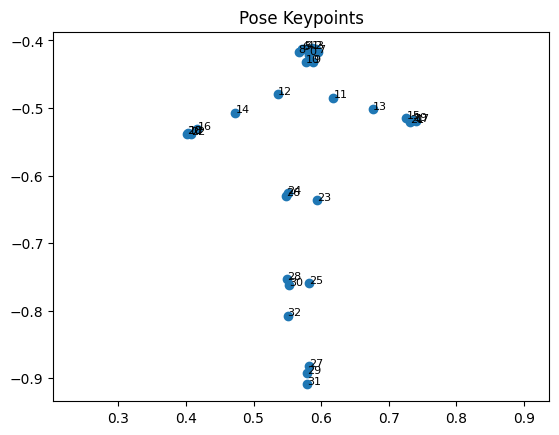

In [45]:
import matplotlib.pyplot as plt
import numpy as np

sample = np.load("pose_data/gukmin/frame_0537.npy")

plt.scatter(sample[:, 0], -sample[:, 1])
for i, (x, y) in enumerate(sample):
    plt.text(x, -y, str(i), fontsize=8)
plt.title("Pose Keypoints")
plt.axis('equal')
plt.show()